In [4]:
import os
import shutil
import cv2
import keras
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
import pydicom
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import tqdm
import glob
import tensorflow
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import random
import gc
import re
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [5]:
SIIM_COVID19_DETECTION_DIR = '/kaggle/input/siim-covid19-detection/'
PART0_RESIZED_DIR = '../input/siim-covid19-resized-to-512px-jpg'


TEMP_DIR = '/kaggle/temp/'

INPUT_DIR = PART0_RESIZED_DIR+'/train/'

OUTPUT_DIR = DATASET_DIR = TEMP_DIR+'/train/'
TRAIN_DIR = DATASET_DIR + 'train/'
TA_DIR = TRAIN_DIR+'ta/'
IA_DIR = TRAIN_DIR+'ia/'
AA_DIR = TRAIN_DIR+'aa/'
NP_DIR = TRAIN_DIR+'np/'

# WORKING_DIR = '/kaggle/working/'

WANDB_PROJECT_NAME = 'project8-kaggle-covid19'
WANDB_ENTITY_NAME = ''

TRAIN_IMAGE_LEVEL_PATH = SIIM_COVID19_DETECTION_DIR+'train_image_level.csv'
TRAIN_STUDY_LEVEL_PATH = SIIM_COVID19_DETECTION_DIR+'train_study_level.csv'
META_PATH = PART0_RESIZED_DIR+'meta.csv'

BATCH_SIZE = 32
EPOCHS = 25
IMG_SIZE = WIDTH = HEIGHT = 224
LEARNING_RATE = 0.00008

# INTERPOLATION = cv2.INTER_LANCZOS4


In [6]:
df_train_image_level = pd.read_csv(TRAIN_IMAGE_LEVEL_PATH)
df_train_study_level = pd.read_csv(TRAIN_STUDY_LEVEL_PATH)

df_train_image_level['id'] = df_train_image_level.apply(lambda row: row.id.split('_')[0], axis=1)
df_train_image_level['path'] = df_train_image_level.apply(lambda row: INPUT_DIR+row.id+'.jpg', axis=1)
df_train_image_level['image_level'] = df_train_image_level.apply(lambda row: row.label.split(' ')[0], axis=1)

df_train_study_level['id'] = df_train_study_level.apply(lambda row: row.id.split('_')[0], axis=1)
df_train_study_level.columns = ['StudyInstanceUID', 'Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

df_train_study_level.head()

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1


In [7]:
df_train_image_level.head()

,id,boxes,label,StudyInstanceUID,path,image_level
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-resized-to-512px-jpg/tra...,opacity
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-resized-to-512px-jpg/tra...,none
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-resized-to-512px-jpg/tra...,opacity
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,../input/siim-covid19-resized-to-512px-jpg/tra...,opacity
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,../input/siim-covid19-resized-to-512px-jpg/tra...,opacity


In [8]:
df_train_image_level = df_train_image_level.merge(df_train_study_level, on='StudyInstanceUID',how="left")
df_train_image_level = df_train_image_level[['id','StudyInstanceUID','path','Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']]
df_train_image_level = df_train_image_level.dropna()
df_train_image_level = df_train_image_level[~df_train_image_level.duplicated(subset=['StudyInstanceUID'], keep='first')]
df_train_image_level = df_train_image_level.reset_index(drop=True)
df_train_image_level.head()

,id,StudyInstanceUID,path,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2,5776db0cec75,../input/siim-covid19-resized-to-512px-jpg/tra...,0,1,0,0
1,000c3a3f293f,ff0879eb20ed,../input/siim-covid19-resized-to-512px-jpg/tra...,1,0,0,0
2,0012ff7358bc,9d514ce429a7,../input/siim-covid19-resized-to-512px-jpg/tra...,0,1,0,0
3,001398f4ff4f,28dddc8559b2,../input/siim-covid19-resized-to-512px-jpg/tra...,0,0,0,1
4,001bd15d1891,dfd9fdd85a3e,../input/siim-covid19-resized-to-512px-jpg/tra...,0,1,0,0


In [9]:
[os.makedirs(dir, exist_ok=True) for dir in [TA_DIR,IA_DIR,AA_DIR,NP_DIR]]
for i in tqdm(range(len(df_train_image_level))):
    row = df_train_image_level.loc[i]
    if row['Typical Appearance']:
        shutil.copy(row.path, f'{TA_DIR}{row.id}.jpg')
    if row['Indeterminate Appearance']:
        shutil.copy(row.path, f'{IA_DIR}{row.id}.jpg')
    if row['Atypical Appearance']:
        shutil.copy(row.path, f'{AA_DIR}{row.id}.jpg')
    if row['Negative for Pneumonia']:
        shutil.copy(row.path, f'{NP_DIR}{row.id}.jpg')


100%|██████████| 6054/6054 [00:38<00:00, 155.37it/s]


In [10]:
datagen_kwargs = dict(validation_split=.20,
                      preprocessing_function=preprocess_input
                     )
dataflow_kwargs = dict(target_size=(IMG_SIZE, IMG_SIZE),
                       batch_size=BATCH_SIZE,
                       interpolation="lanczos"
                      )

In [11]:

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(TRAIN_DIR,
                                                    subset="validation",
                                                    shuffle=False,
                                                    **dataflow_kwargs)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    **datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    subset="training",
                                                    shuffle=True,
                                                    **dataflow_kwargs)

print('classes :', train_generator.class_indices)

Found 1209 images belonging to 4 classes.
Found 4845 images belonging to 4 classes.
classes : {'aa': 0, 'ia': 1, 'np': 2, 'ta': 3}


In [12]:
base_model = MobileNet(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

17227776/17225924 [==============================] - 1s 0us/step


In [13]:
for layer in base_model.layers:
    layer.trainable=False

In [14]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50176)             200704    
_________________________________________________________________
dense (Dense)                (None, 2048)              102762496 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

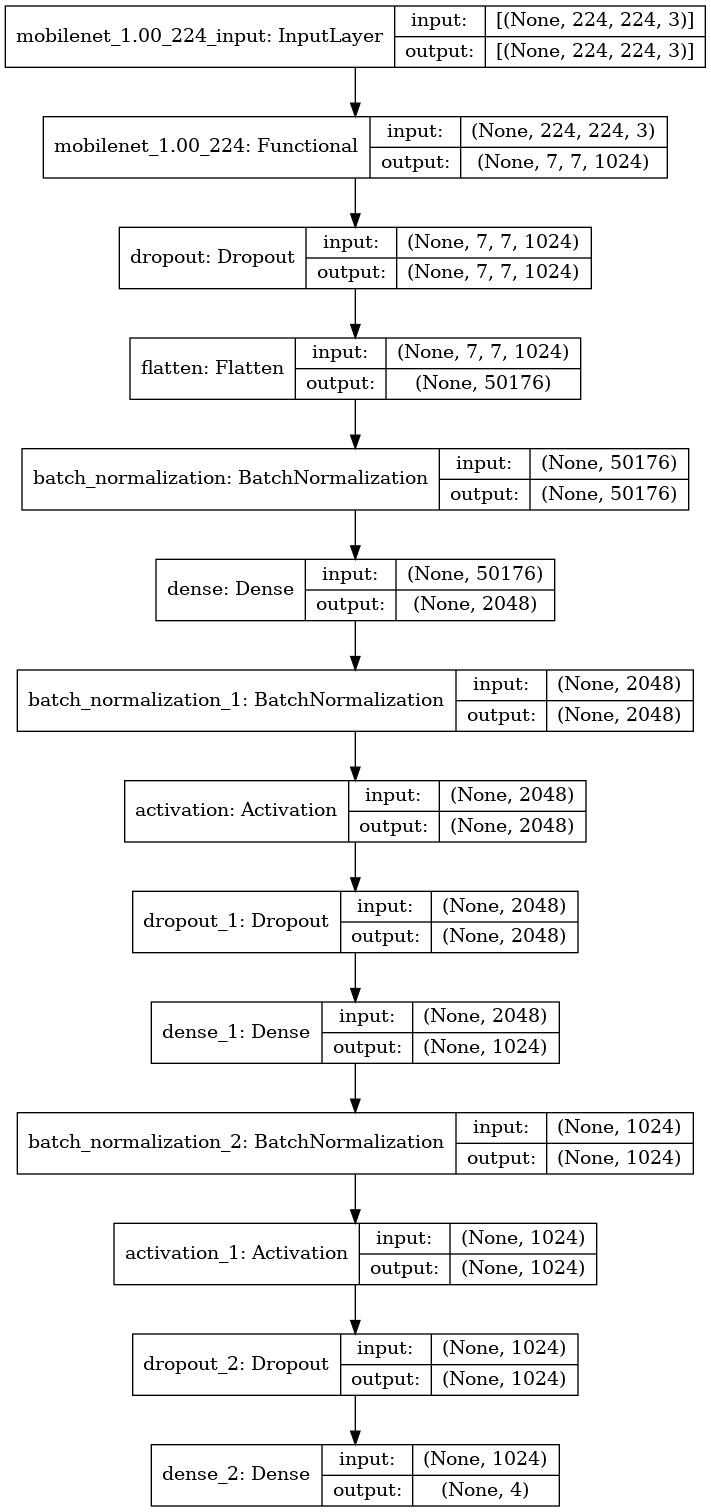

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

In [17]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [18]:
filepath = './best_weights_MobileNet.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [19]:
model_history=model.fit(train_generator,
                        validation_data=valid_generator,
                        epochs = 30,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/30
152/152 [==============================] - 95s 572ms/step - loss: 1.6885 - auc: 0.6941 - val_loss: 1.5794 - val_auc: 0.7428

Epoch 00001: val_auc improved from -inf to 0.74282, saving model to ./best_weights_MobileNet.hdf5
Epoch 2/30
152/152 [==============================] - 87s 572ms/step - loss: 1.2579 - auc: 0.7368 - val_loss: 1.3552 - val_auc: 0.7432

Epoch 00002: val_auc improved from 0.74282 to 0.74316, saving model to ./best_weights_MobileNet.hdf5
Epoch 3/30
152/152 [==============================] - 86s 568ms/step - loss: 1.1309 - auc: 0.7491 - val_loss: 1.1748 - val_auc: 0.7531

Epoch 00003: val_auc improved from 0.74316 to 0.75307, saving model to ./best_weights_MobileNet.hdf5
Epoch 4/30
152/152 [==============================] - 87s 570ms/step - loss: 1.1165 - auc: 0.7488 - val_loss: 1.0699 - val_auc: 0.7654

Epoch 00004: val_auc improved from 0.75307 to 0.76538, saving model to ./best_weights_MobileNet.hdf5
Epoch 5/30
152/152 [==============================] - 8

In [20]:
model.save('./best_weights_MobileNet.hdf5')

In [21]:
# model_path = '../input/kaggle-covid19/best_weights_sigmoid.hdf5'
# model = keras.models.load_model(model_path)

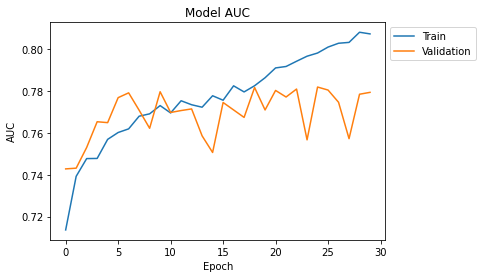

In [22]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [23]:
fig0 = cv2.imread('../input/siim-covid19-resized-to-512px-jpg/train/000a312787f2.jpg')
fig1 = fig0.resize((224,224,3)) 
fig2 = preprocess_input(fig0)
fig0.shape , fig2.shape
fig2 = np.reshape(fig2,[1,224,224,3])
a0 = model.predict(fig2)
a = a0[0]>0.7
b=np.zeros((np.size(a)))
for i in range(len(a)):
    print(a[i],b[i],i)
    if a[i]:
        b[i]=1
b

False 0.0 0
True 0.0 1
False 0.0 2
True 0.0 3


array([0., 1., 0., 1.])

In [24]:
pip install pylibjpeg pylibjpeg-libjpeg pydicom GDCM 

     |████████████████████████████████| 4.2 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 884 kB 10.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
